# A Neural Algorithm of Artistic Style

#### Contents
    1. Introduction
    2. Import Libraries
    3. Load Style and Content Image
    4. Load Pre-trained VGG19 Model
    5. Utilities
    6. Generate Images
    7. Save the Model
    8. References

## 1. Introduction
Neural Style Transfer is initially introduced and developed at ['A Neural Algorithm of Artistic Style'](https://arxiv.org/pdf/1508.06576.pdf) by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge in 2015. Three images - an input image, a content image, and a style image - are fed into the algorithm and converts the input image to take after the feature of the content image and artistic style of the style image. Recently, a photo-editing application named PRISMA(2016) gained significant popularity. The app is based on the paper aforementioned and we will make a model that provides a similar outputs.

Here we introduce an artificial system based on a Deep Neural Network that creates artistic images of high perceptual quality. The system uses neural representations to separate and recombine content and style of arbitrary images, providing a neural algorithm for the creation of artistic images. - Leon A. Gatys

![NeuralStyleTransfer_Diagram](./images/NeuralStyleTransfer_Diagram.png)
[Image Source](https://hackernoon.com/how-do-neural-style-transfers-work-7bedaee0559a)

This notebook provides a code for [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), the second version of Neural Style Transfer written by the author. He took advantage of deeper hidden layers that contain feature vectors, or information, of an image. 

## 2. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cpu


## 3. Load Style and Content Image

In [4]:
def image_loader(image_path):
    
    # consider computational resources
    image_size = 512 if device == "cuda" else 128
    
    # define transform of an image
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.485, 0.456, 0.406), 
                             std = (0.229, 0.224, 0.225))
    ])
    
    image = Image.open(image_path).convert('RGB')
    
    # discard the transparent alpha channel [:3]
    image = transform(image)[:3, :, :]
    
    # add batch dimension
    image = image.unsqueeze(dim = 0)
    
    return image.to(device)

In [5]:
# load content image
content_image = image_loader('./images/space_needle.jpg')

In [6]:
# load style image
style_image = image_loader('./images/delaunay.jpg')

In [7]:
# check whether they have the same dimension
content_image.size(), style_image.size()

(torch.Size([1, 3, 128, 128]), torch.Size([1, 3, 128, 128]))

In [8]:
# define a function that converts a tensor to numpy for display
def tensor2np(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

(-0.5, 127.5, 127.5, -0.5)

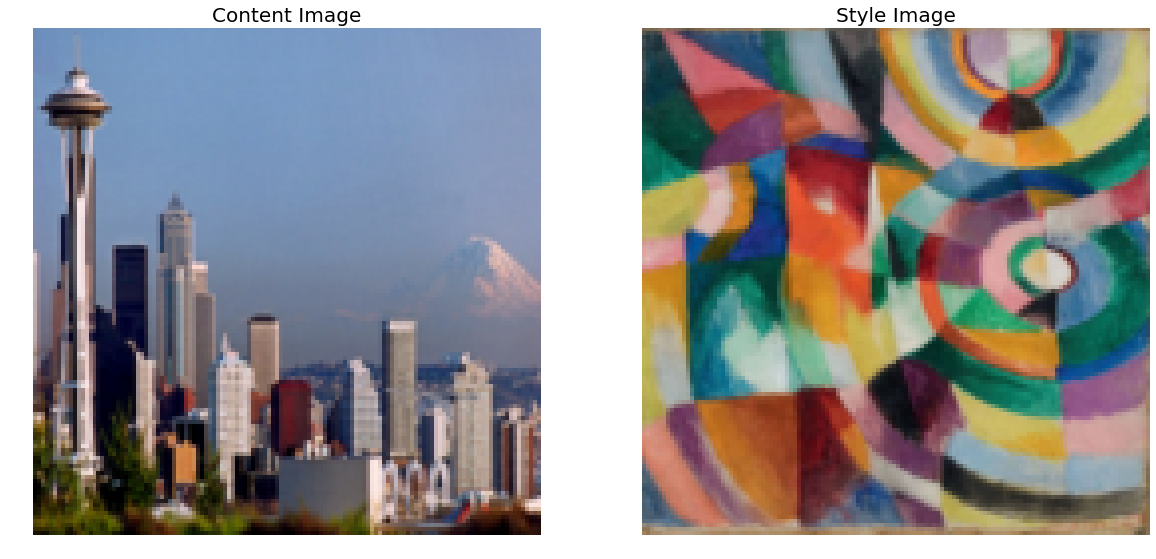

In [9]:
# discplay images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(tensor2np(content_image))
ax1.set_title("Content Image", fontsize = 20)
ax1.axis("off")
ax2.imshow(tensor2np(style_image))
ax2.set_title("Style Image", fontsize = 20)
ax2.axis("off")

## 4. Load Pre-trained VGG19 Model
![Overview](./Images/Overview.png)
VGG19 has two parts, `vgg19.features` and `vgg19.classifier`. 
- `vgg19.features` has convolutional layers and pooling layers
- `vgg19.classifier` has three linear layers and softmax classifier at the end

In [10]:
# import pre-trained vgg19 model and its feature (excluding layers for classification)
vgg19 = models.vgg19(pretrained = True).features

In [11]:
# freeze all VGG19 parameters
for param in vgg19.parameters():
    param.requires_grad_(False)

In [12]:
vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

Replacing max-pooling operation by average-pooling improves gradient flow, prevents information loss and produces more appealing results thus all max-pooling layers are replaced to average-pooling layers. Thus by defining `pooling_change` function, change all `MaxPool2d` layers to `AvgPool2d`.

In [13]:
def pooling_change(model):
    ct=0
    for layer in model.children():
        if isinstance(layer, nn.MaxPool2d):
            model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        ct+=1
    return model

In [14]:
vgg19 = pooling_change(vgg19)

In [15]:
vgg19.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1)

## 5. Utilities
List layers for the content and the style representations from PyTorch's VGGNet architecture and define `get_features` function from content image and style image.

In [16]:
def get_features(image, model):
    
    layers = {'0': 'conv1_1',  # style representation
              '5': 'conv2_1',  # style representation
              '10': 'conv3_1', # style representation
              '19': 'conv4_1', # style representation
              '21': 'conv4_2', # content representation
              '28': 'conv5_1'} # style representation
        
    features = {}
    x = image
    
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [17]:
# get features from content image and style image
content_features = get_features(content_image, vgg19)
style_features = get_features(style_image, vgg19)

### 5.1 Gram Matrix
To gain the information of relation between different filters and channels, dot product between the vectors of two filters should be known. This is obtained through Gram Matrices. The bigger the result is, the more relationship in between. 
![GramMatrices](./Images/GramMatrices.png)

A tensor is an output from every convolutional layer, having the shape of (batch size, depth, height, weight). This can be derived from `batch_size, d, h, w = tensor.size() or tensor.shape`.
1. Get the dimension of a tensor using `tensor.shape` or `tensor.size()`.
2. Next, flatten the dimension by using `view`.
3. Calculate the gram matrix by multiplying the reshaped tensor by its transpose, using `torch.mm(a, b)`.

In [18]:
def gram_matrix(tensor):
    
    # get shape of a tensor
    b_size, d, h, w = tensor.size()
    
    # flatten the dimension
    tensor = tensor.view(b_size * d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [19]:
# calculate the gram matrices for each layer of style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

### 5.2 Content Loss
Content loss is a squared-error loss between the feature representation of the content image and that of style image. It indicates how similar the randomly generated noisy image is to the content image. F and P indicates the original image and generated image respectively, F[l] and P[l] represents images at specific layer of l.
![StyleLoss](./Images/ContentLoss.png)

In [ ]:
# this code is not used during the training.

class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
        
    def forward(self, inputs):
        self.loss = self.criterion.forward(input * self.weight, self.target)
        self.output = input
        return self.output
    
    def backward(self, retain_graph = True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

### 5.3 Style Loss
Style Loss is the mean squared distance between the style representation of the style image and that of the output image at a specific layer l.
![StyleLoss](./Images/StyleLoss.png)
<br> To calculate the total loss, loss function is applied to every different layers.
![StyleLossTotal](./Images/StyleLossTotal.png)

In [ ]:
# this code is not used during the training.

class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = gram_matrix()
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input)
        self.G.mul(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph = True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

### 5.4 Transfer Learning Loss

![TransferLearningLoss](./Images/TransferLearningLoss.png)
This equation represents the loss of transfer learning, or simply total loss. By changing the hyper-parameters, it is able to control the similarity between content image and style image. The ratio between coefficients is in the order of 10,000. But due to high factor of style weight, the style image dominates the content image, creating an intersting result.

In [20]:
content_weight = 1  # alpha
style_weight = 1e5  # beta

### 6. Generate Images
`style weights` are assigned to style layers which determines the similarity between content image and style image.

In [21]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [22]:
# define target_image which is a copy of content_iamge.
target_image = content_image.clone().requires_grad_(True).to(device)

Even though the trendy optimization function is `Adam`, the paper used `L-BFGS` which leads to generating better image.
<br> [Picking an optimizer for Style Transfer
](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b)

In [23]:
optimizer = optim.LBFGS([target_image], lr=0.003)

Step: 50/1000 Total loss: 1111820.3750 Content loss: 0.2328 Style loss: 11.1182


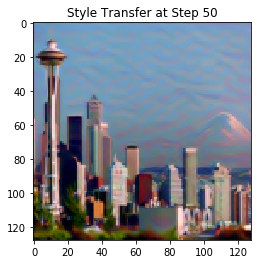

Step: 100/1000 Total loss: 529090.7500 Content loss: 0.4761 Style loss: 5.2909


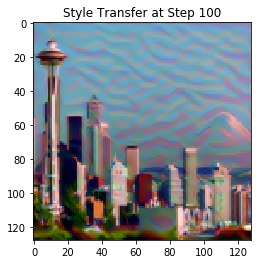

Step: 150/1000 Total loss: 343821.1250 Content loss: 0.6037 Style loss: 3.4382


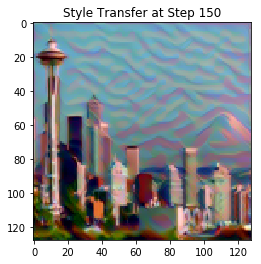

Step: 200/1000 Total loss: 254666.2031 Content loss: 0.6958 Style loss: 2.5467


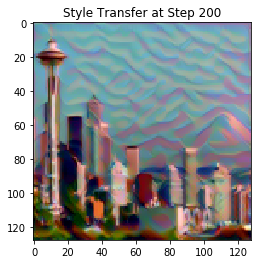

Step: 250/1000 Total loss: 200486.9062 Content loss: 0.7657 Style loss: 2.0049


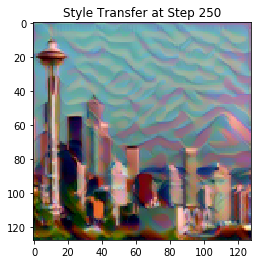

Step: 300/1000 Total loss: 164601.0469 Content loss: 0.8184 Style loss: 1.6460


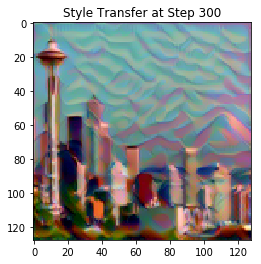

Step: 350/1000 Total loss: 139169.0625 Content loss: 0.8629 Style loss: 1.3917


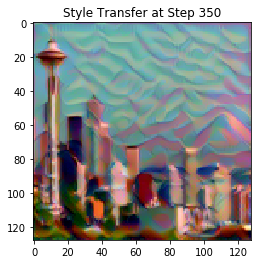

Step: 400/1000 Total loss: 120142.6172 Content loss: 0.9032 Style loss: 1.2014


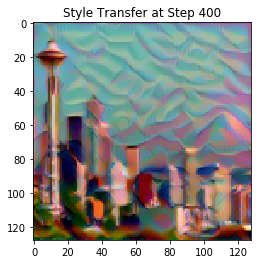

Step: 450/1000 Total loss: 105284.5781 Content loss: 0.9414 Style loss: 1.0528


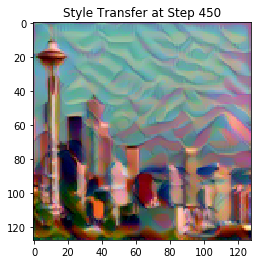

Step: 500/1000 Total loss: 93328.7109 Content loss: 0.9781 Style loss: 0.9333


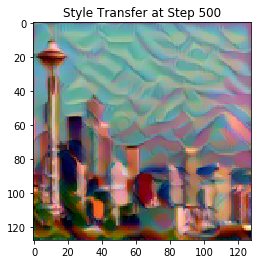

Step: 550/1000 Total loss: 83500.5078 Content loss: 1.0140 Style loss: 0.8350


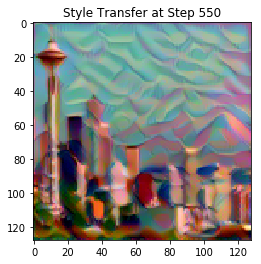

Step: 600/1000 Total loss: 75195.3828 Content loss: 1.0492 Style loss: 0.7519


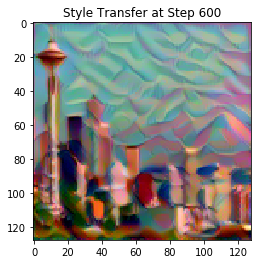

Step: 650/1000 Total loss: 68051.7266 Content loss: 1.0824 Style loss: 0.6805


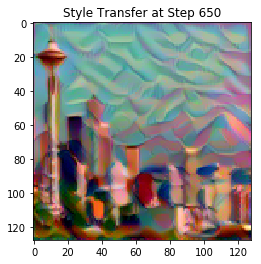

Step: 700/1000 Total loss: 61870.3359 Content loss: 1.1111 Style loss: 0.6187


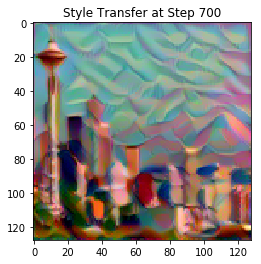

Step: 750/1000 Total loss: 56471.0977 Content loss: 1.1374 Style loss: 0.5647


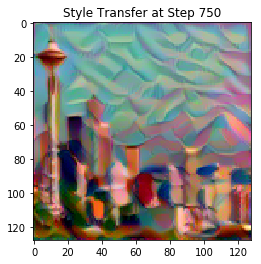

Step: 800/1000 Total loss: 51726.8203 Content loss: 1.1606 Style loss: 0.5173


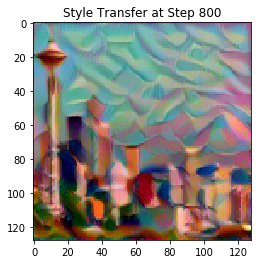

Step: 850/1000 Total loss: 47533.0938 Content loss: 1.1821 Style loss: 0.4753


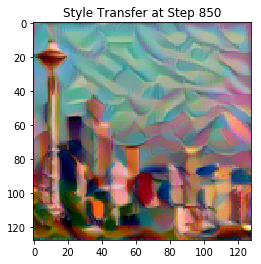

Step: 900/1000 Total loss: 43799.6211 Content loss: 1.2029 Style loss: 0.4380


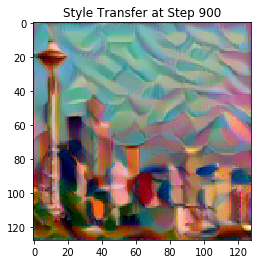

Step: 950/1000 Total loss: 40485.0898 Content loss: 1.2233 Style loss: 0.4048


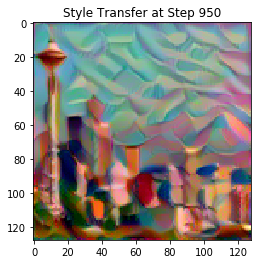

Step: 1000/1000 Total loss: 37527.4570 Content loss: 1.2434 Style loss: 0.3753


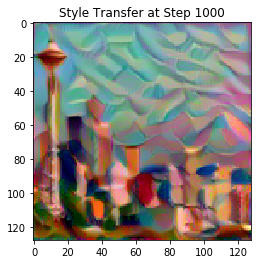

<Figure size 432x288 with 0 Axes>

In [24]:
# parameters for training
show_every = 50
steps = 1000

# training
for step in range(steps):
    
    # get features from the target image (cloned from content image)
    target_features = get_features(target_image, vgg19)
    
    # calculate the content loss from conv4_2 layer
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # initialize style loss
    style_loss = 0
    
    # calculate the style loss
    for layer in style_weights:
        
        # for each layer's features in target features
        target_feature = target_features[layer]
        
        # calculate the gram matrix
        target_gram = gram_matrix(target_feature)
        
        # and get the shape of the target feature
        _, d, h, w = target_feature.shape
        
        # also get the style from style representation
        style_gram = style_grams[layer]
        
        # the style loss for each layer
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # transfer learning loss    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # back propagation and update
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    if (step+1) % show_every == 0:
        # print statistics
        print('Step: {}/{} Total loss: {:.4f} Content loss: {:.4f} Style loss: {:.4f}'
              .format(step+1, steps, total_loss.item(), content_loss.item(), style_loss.item()))
              
        # display generated images
        plt.imshow(tensor2np(target_image))
        plt.title("Style Transfer at Step {}".format(step+1))
        plt.show()
        plt.savefig('./Images/StyleTransferAtStep_{}'.format(step+1))

(-0.5, 127.5, 127.5, -0.5)

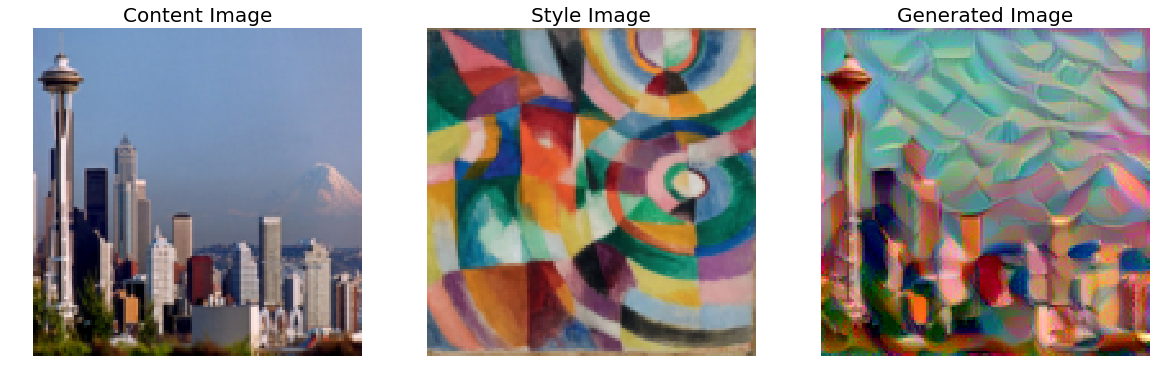

In [25]:
# discplay resulting images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.imshow(tensor2np(content_image))
ax1.set_title("Content Image", fontsize = 20)
ax1.axis("off")

ax2.imshow(tensor2np(style_image))
ax2.set_title("Style Image", fontsize = 20)
ax2.axis("off")

ax3.imshow(tensor2np(target_image))
ax3.set_title("Generated Image", fontsize = 20)
ax3.axis("off")

It works! As it took around 5 hours to complete, I recommend to shorten the step to 500 as the results are more or less similar from that step or use GPU for faster generation.

### 8. Acknowledgement and References

Special thanks to [Udacity Style Transfer Github Repository](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/style-transfer). I failed to implement neural style transfer for many times (almost no loss at the very beginning, where there should be a gigantic loss!) and after referring to this repository, I successfully made it. 

- [Udacity / deep-learning-v2-pytorch / style-transfer](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/style-transfer)
- [Author's Original Code on A Neural Algorithm of Artistic Style](https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb)
- [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)